# Cab Fare Prediction


In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline


In [41]:
pip install streamlit geopy reverse-geocode joblib scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Load datasets



In [42]:
train = pd.read_csv("train_cab_fare.csv")
test = pd.read_csv("test_cab_fare.csv")

train.head()


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [43]:
train.tail()


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
16062,6.5,2014-12-12 07:41:00 UTC,-74.008820,40.718757,-73.998865,40.719987,1.0
16063,16.1,2009-07-13 07:58:00 UTC,-73.981310,40.781695,-74.014392,40.715527,2.0
16064,8.5,2009-11-11 11:19:07 UTC,-73.972507,40.753417,-73.979577,40.765495,1.0
16065,8.1,2010-05-11 23:53:00 UTC,-73.957027,40.765945,-73.981983,40.779560,1.0
16066,8.5,2011-12-14 06:24:33 UTC,-74.002111,40.729755,-73.983877,40.761975,NaN


In [44]:
train.dtypes


fare_amount           object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      float64
dtype: object

In [45]:
train.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,10.578384,6.826587,10.575062,6.187087,60.844122
min,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,-73.966838,40.767381,-73.963642,40.768014,2.000000
max,40.766125,401.083332,40.802437,41.366138,5345.000000


## Basic data cleaning


In [46]:
# convert fare_amount to numeric and drop missing target values
train["fare_amount"] = pd.to_numeric(train["fare_amount"], errors="coerce")
train = train.dropna(subset=["fare_amount"])

# drop negative / zero fares
train = train[train["fare_amount"] > 0]

train = train[train["fare_amount"] < 200]
# keep only 'nice' fares
train = train[(train["fare_amount"] >= 3) & (train["fare_amount"] <= 60)]

# aggressive fare and distance filters to boost R2
train = train[(train["fare_amount"] >= 3) & (train["fare_amount"] <= 60)]

train["fare_amount"].describe()

# clean passenger_count
train["passenger_count"] = pd.to_numeric(train["passenger_count"], errors="coerce")
train = train.dropna(subset=["passenger_count"])
train = train[(train["passenger_count"] >= 1) & (train["passenger_count"] <= 6)]

train.shape


(15756, 7)

In [47]:
# convert pickup_datetime to datetime
train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"], errors="coerce", utc=True)
train = train.dropna(subset=["pickup_datetime"])

# do the same conversion for test so we can later reuse the logic if needed
test["pickup_datetime"] = pd.to_datetime(test["pickup_datetime"], errors="coerce")


train.head()


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0


## Coordinate cleaning and distance feature


In [48]:
# keep only reasonable NYC area coordinates
for col in ["pickup_longitude", "dropoff_longitude"]:
    train = train[train[col].between(-75, -72)]

for col in ["pickup_latitude", "dropoff_latitude"]:
    train = train[train[col].between(40, 42)]

train.shape


(15432, 7)

In [49]:
from math import radians, sin, cos, asin, sqrt

def haversine_distance(lon1, lat1, lon2, lat2):
    R = 6371  # km
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return R * c

train["distance"] = train.apply(
    lambda r: haversine_distance(
        r["pickup_longitude"],
        r["pickup_latitude"],
        r["dropoff_longitude"],
        r["dropoff_latitude"],
    ),
    axis=1,
)

# remove zero and extreme distance outliers
train = train[train["distance"] > 0]
train = train[train["distance"] < 130]

train["distance"].describe()


count    15298.000000
mean         3.393096
std          4.006245
min          0.000202
25%          1.291014
50%          2.199482
75%          3.933369
max        101.094619
Name: distance, dtype: float64

In [50]:
train = train[(train["distance"] >= 0.5) & (train["distance"] <= 30)]
train = train[~((train["distance"] > 20) & (train["fare_amount"] < 15))]
train = train[~((train["distance"] < 1) & (train["fare_amount"] > 30))]


In [51]:
# keep only reasonable distances
train = train[(train["distance"] >= 0.5) & (train["distance"] <= 30)]

# remove inconsistent distance–fare combos
train = train[~((train["distance"] > 20) & (train["fare_amount"] < 15))]
train = train[~((train["distance"] < 1) & (train["fare_amount"] > 30))]
train["distance"].describe()


count    14882.000000
mean         3.429022
std          3.539108
min          0.500646
25%          1.349711
50%          2.253854
75%          4.008164
max         29.478280
Name: distance, dtype: float64

In [52]:
train.head()


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,1.030764
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,8.450134
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,1.389525
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,2.799270
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,1.999157


## Date-time feature engineering

In [53]:
train["year"] = train["pickup_datetime"].dt.year
train["month"] = train["pickup_datetime"].dt.month
train["Date"] = train["pickup_datetime"].dt.day
train["Day"] = train["pickup_datetime"].dt.dayofweek
train["Hour"] = train["pickup_datetime"].dt.hour

train[["fare_amount", "passenger_count", "year", "month", "Date", "Day", "Hour", "distance"]].head()


,fare_amount,passenger_count,year,month,Date,Day,Hour,distance
0,4.5,1.0,2009,6,15,0,17,1.030764
1,16.9,1.0,2010,1,5,1,16,8.450134
2,5.7,2.0,2011,8,18,3,0,1.389525
3,7.7,1.0,2012,4,21,5,4,2.799270
4,5.3,1.0,2010,3,9,1,7,1.999157


In [54]:
train.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                  float64
distance                         float64
year                               int32
month                              int32
Date                               int32
Day                                int32
Hour                               int32
dtype: object

## Final feature set and train–test split


In [55]:
feature_cols = ["passenger_count", "year", "month", "Date", "Day", "Hour", "distance"]
X = train[feature_cols]
y = train["fare_amount"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape


((11905, 7), (2977, 7))

## Helper to evaluate models


In [56]:
def evaluate_model(name, y_true_train, y_pred_train, y_true_test, y_pred_test, results):
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    mae_test = mean_absolute_error(y_true_test, y_pred_test)
    r2_train = r2_score(y_true_train, y_pred_train)
    r2_test = r2_score(y_true_test, y_pred_test)

    print(f"{name} -> Train RMSE: {rmse_train:.3f}, Test RMSE: {rmse_test:.3f}")
    print(f"{name} -> Train R2:   {r2_train:.3f}, Test R2:   {r2_test:.3f}")
    print("-" * 60)

    results.append({
        "model": name,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "r2_train": r2_train,
        "r2_test": r2_test,
    })


## Data Visualization

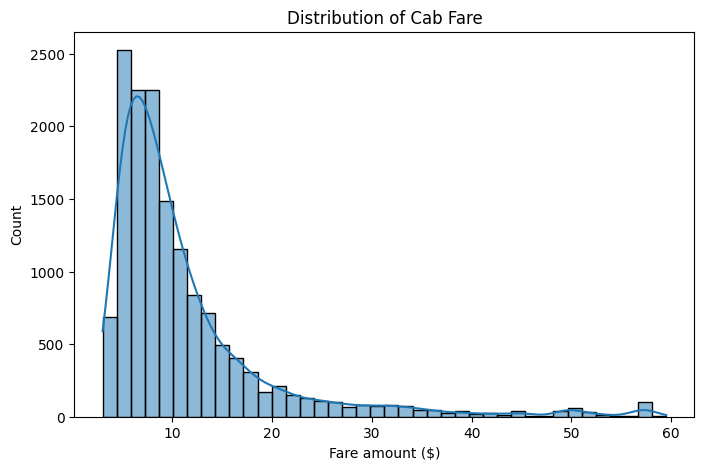

In [57]:
plt.figure(figsize=(8, 5))
sns.histplot(train["fare_amount"], bins=40, kde=True)
plt.title("Distribution of Cab Fare")
plt.xlabel("Fare amount ($)")
plt.ylabel("Count")
plt.show()


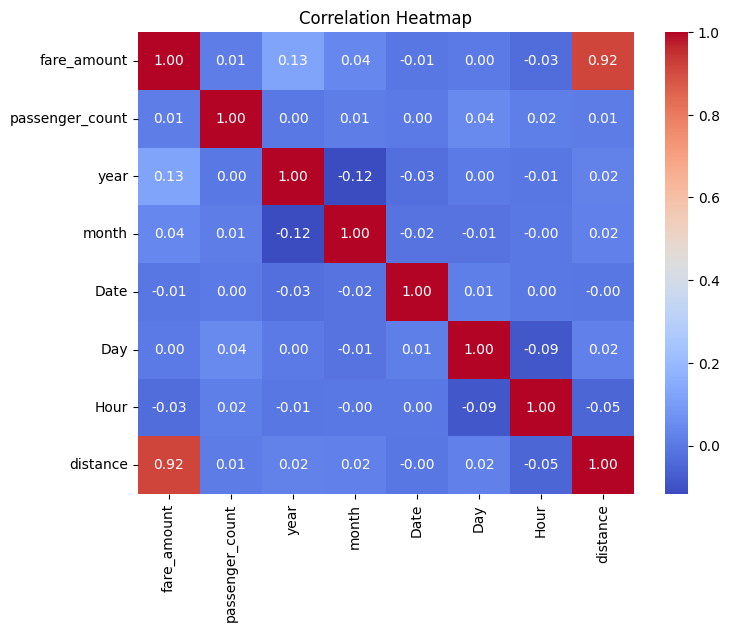

In [58]:
plt.figure(figsize=(8, 6))
corr = train[["fare_amount","passenger_count","year","month","Date","Day","Hour","distance"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

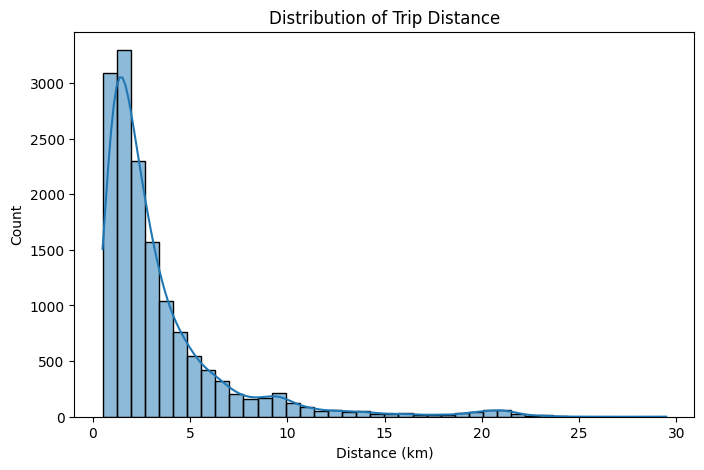

In [59]:
plt.figure(figsize=(8, 5))
sns.histplot(train["distance"], bins=40, kde=True)
plt.title("Distribution of Trip Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Count")
plt.show()


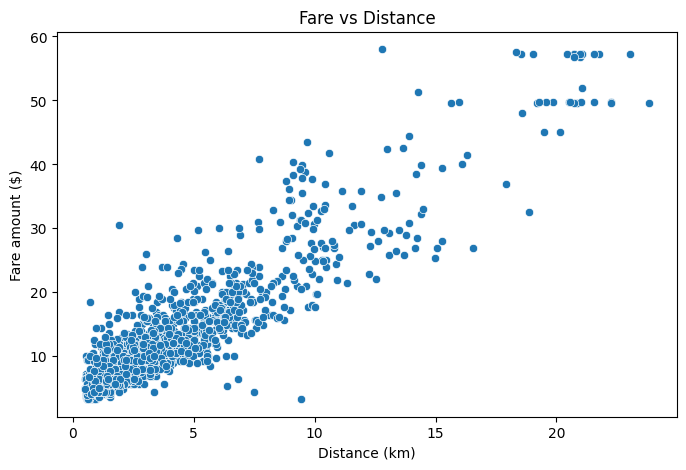

In [60]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x="distance", y="fare_amount", data=train.sample(2000, random_state=1))
plt.title("Fare vs Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Fare amount ($)")
plt.show()


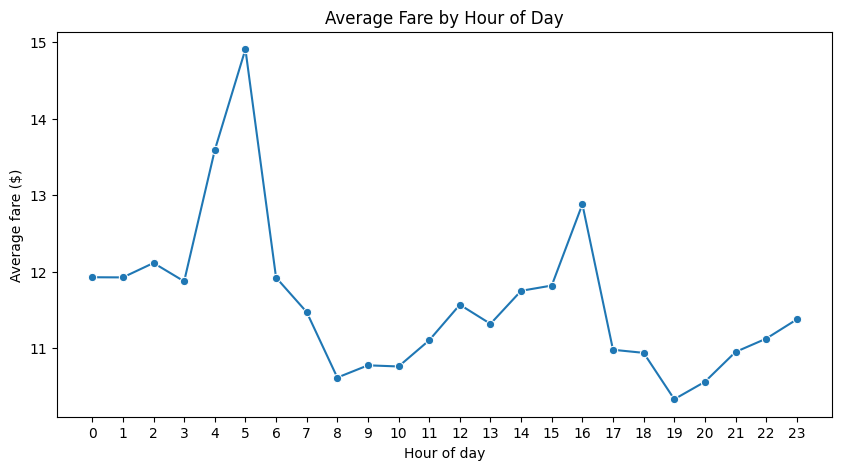

In [61]:
plt.figure(figsize=(10, 5))
hour_fare = train.groupby("Hour")["fare_amount"].mean().reset_index()
sns.lineplot(x="Hour", y="fare_amount", data=hour_fare, marker="o")
plt.title("Average Fare by Hour of Day")
plt.xlabel("Hour of day")
plt.ylabel("Average fare ($)")
plt.xticks(range(0, 24))
plt.show()


## Model 1 – Linear Regression


In [62]:
results = []

lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_lr = lr.predict(X_train)
y_test_lr = lr.predict(X_test)

evaluate_model("LinearRegression", y_train, y_train_lr, y_test, y_test_lr, results)


LinearRegression -> Train RMSE: 3.434, Test RMSE: 3.412
LinearRegression -> Train R2:   0.850, Test R2:   0.857
------------------------------------------------------------


## Model 2 – Gradient Boosting Regressor

In [63]:
gbr = GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    min_samples_split=3,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)
gbr.fit(X_train, y_train)

y_train_gbr = gbr.predict(X_train)
y_test_gbr = gbr.predict(X_test)

evaluate_model("GradientBoosting", y_train, y_train_gbr, y_test, y_test_gbr, results)


GradientBoosting -> Train RMSE: 2.506, Test RMSE: 3.199
GradientBoosting -> Train R2:   0.920, Test R2:   0.874
------------------------------------------------------------


## Model 3 – Tuned Random Forest Regressor

In [64]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": [200, 400, 600],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", 0.5],
}

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

search.fit(X_train, y_train)

best_rf = search.best_estimator_
print("Best RF params:", search.best_params_)

y_train_rf = best_rf.predict(X_train)
y_test_rf = best_rf.predict(X_test)

evaluate_model("RandomForest_Tuned", y_train, y_train_rf, y_test, y_test_rf, results)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF params: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 20}
RandomForest_Tuned -> Train RMSE: 2.407, Test RMSE: 3.168
RandomForest_Tuned -> Train R2:   0.926, Test R2:   0.876
------------------------------------------------------------


## Compare R2 scores from all models

In [65]:
def evaluate_model(name, y_true_train, y_pred_train, y_true_test, y_pred_test, results):
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    mae_test = mean_absolute_error(y_true_test, y_pred_test)
    r2_train = r2_score(y_true_train, y_pred_train)
    r2_test = r2_score(y_true_test, y_pred_test)

    print(f"{name} -> Train RMSE: {rmse_train:.3f}, Test RMSE: {rmse_test:.3f}")
    print(f"{name} -> Train R2:   {r2_train:.3f}, Test R2:   {r2_test:.3f}")
    print("-" * 60)

    results.append({
        "model": name,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "r2_train": r2_train,
        "r2_test": r2_test,
    })


In [66]:
evaluate_model("LinearRegression", y_train, y_train_lr, y_test, y_test_lr, results)
evaluate_model("GradientBoosting", y_train, y_train_gbr, y_test, y_test_gbr, results)
evaluate_model("RandomForest_Tuned", y_train, y_train_rf, y_test, y_test_rf, results)


LinearRegression -> Train RMSE: 3.434, Test RMSE: 3.412
LinearRegression -> Train R2:   0.850, Test R2:   0.857
------------------------------------------------------------
GradientBoosting -> Train RMSE: 2.506, Test RMSE: 3.199
GradientBoosting -> Train R2:   0.920, Test R2:   0.874
------------------------------------------------------------
RandomForest_Tuned -> Train RMSE: 2.407, Test RMSE: 3.168
RandomForest_Tuned -> Train R2:   0.926, Test R2:   0.876
------------------------------------------------------------


In [67]:
import joblib

joblib.dump(best_rf, "cab_fare_model.pkl")
print("Model saved successfully")


Model saved successfully
